In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 2 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 2 1 2 0 0 0 0 0 1 0 1 0]


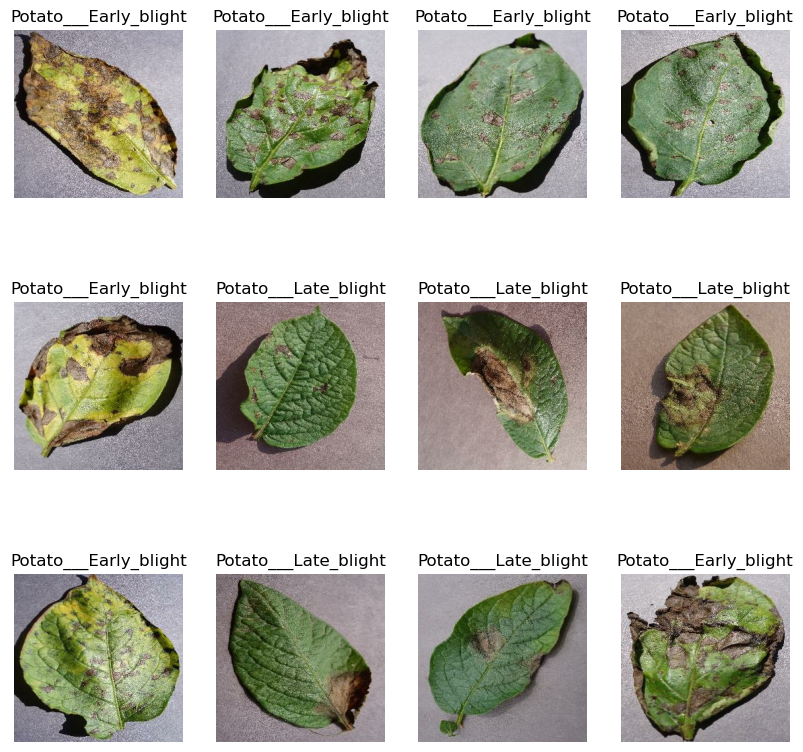

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [10]:
test_dataset = dataset.skip(54)
len(test_dataset)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_dataset = test_dataset.take(6)
len(val_dataset)

6

In [13]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [14]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_dataset = dataset.take(train_size)
    
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

In [15]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [16]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

54
6
8


In [17]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [20]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\ninad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.4554 - loss: 0.9606 - val_accuracy: 0.6094 - val_loss: 0.8425
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6609 - loss: 0.7433 - val_accuracy: 0.7604 - val_loss: 0.5219
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7931 - loss: 0.4580 - val_accuracy: 0.8490 - val_loss: 0.3852
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8837 - loss: 0.3031 - val_accuracy: 0.8229 - val_loss: 0.3926
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.8808 - loss: 0.3000 - val_accuracy: 0.8802 - val_loss: 0.2115
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9252 - loss: 0.1867 - val_accuracy: 0.8698 - val_loss: 0.3663
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9354 - loss: 0.1880 - val_accuracy: 0.9271 - val_loss: 0.1513
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9350 - loss: 0.1684 - val_accuracy: 0.8854 - val_loss

In [25]:
scores = model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - accuracy: 0.9879 - loss: 0.0542


In [26]:
scores

[0.08507418632507324, 0.984375]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9174392819404602,
 0.6767584681510925,
 0.4050300717353821,
 0.3277711272239685,
 0.2758955657482147]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

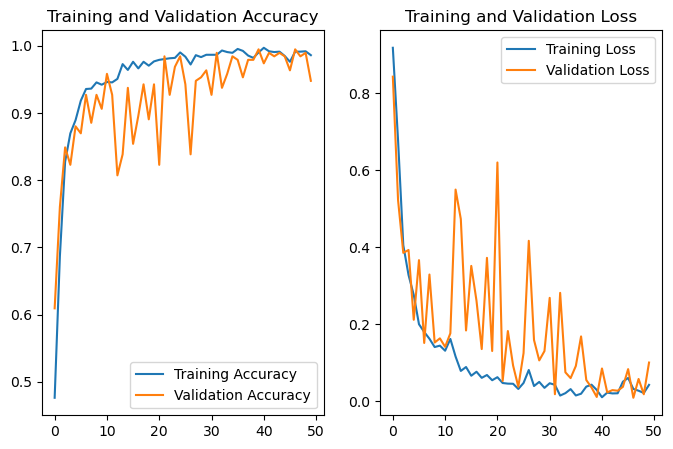

In [38]:
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
predicted label: Potato___Early_blight


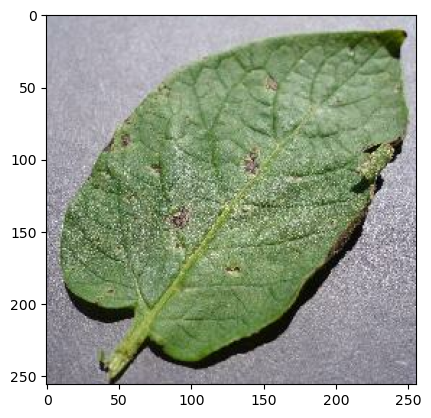

In [39]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


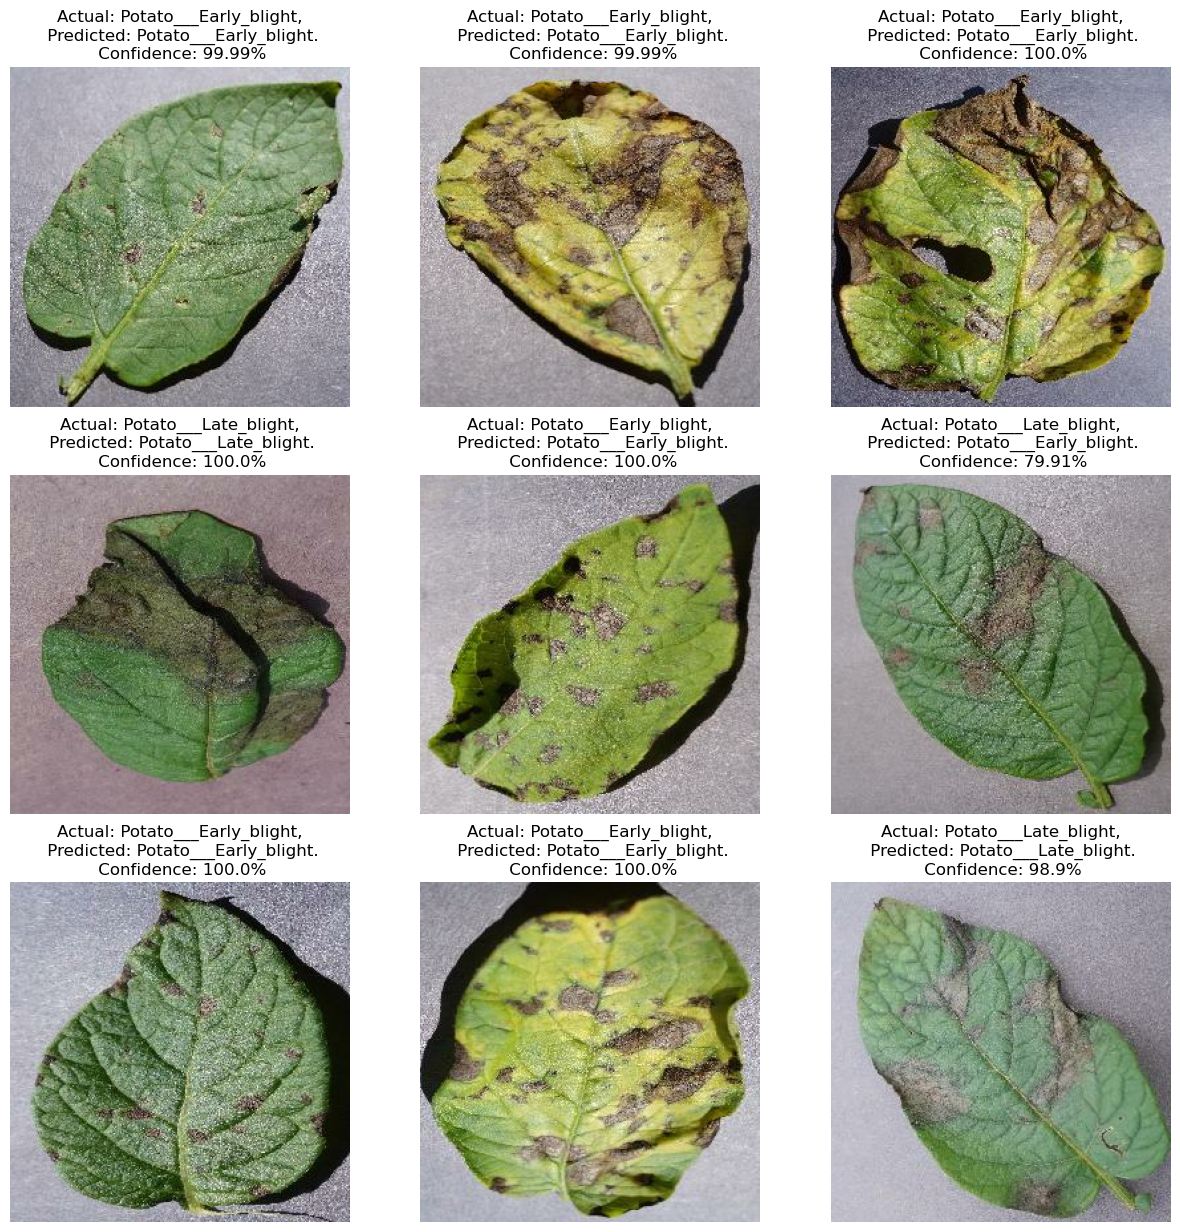

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
import os
model_version=max([int(i) for i in os.listdir("C:\Users\ninad\OneDrive\Desktop\ML Projects (end to end)\Potato Disease") + [0]])+1
model.save(f""C:\Users\ninad\OneDrive\Desktop\ML Projects (end to end)\Potato Disease"{model_version}")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (975324708.py, line 2)